In [2]:
import calibration as _cal 
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import matrix_power
from scipy.linalg import expm, expm_frechet, block_diag

In [3]:
reload(_cal)

<module 'calibration' from '/home/jpmarceaux/VSProjects/CRCalibration/calibration.py'>

circ_defs: a tuple (prep, meas, omega)
edesign: a dictionary with a map between depths and a list of circ defs for each depth

In [4]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))



In [5]:
def modelFsim(theta, phi, chi):
    # equation 12 in https://arxiv.org/pdf/2209.11207.pdf
    return np.array([[np.exp(-1j*phi)*np.cos(theta), -1j * np.exp(1j*chi) * np.sin(theta)],
                     [-1j * np.exp(-1j*chi) * np.sin(theta), np.exp(1j*phi)*np.cos(theta)]])

def modelFsimDeriv(theta, phi, chi):
    Dtheta = np.array([[-np.exp(-1j*phi)*np.sin(theta), -1j * np.exp(1j*chi) * np.cos(theta)],
                        [-1j * np.exp(-1j*chi) * np.cos(theta), -np.exp(1j*phi)*np.sin(theta)]])
    Dphi = np.array([[-1j*np.exp(-1j*phi)*np.cos(theta), 0], 
                    [0, 1j*np.exp(1j*phi)*np.cos(theta)]])
    Dchi = np.array([[0, np.exp(1j*chi)*np.sin(theta)], 
                    [-np.exp(-1j*chi)*np.sin(theta), 0]])
    return np.array([Dtheta, Dphi, Dchi])

In [6]:
# check the definition of the derivative
epsilons = 0.001*np.random.rand(3)
theta, phi, chi = 2*np.pi*np.random.rand(3)
Fsim = modelFsim(theta, phi, chi)
Fsim_dtheta = modelFsim(theta+epsilons[0], phi, chi)
Fsim_dphi = modelFsim(theta, phi+epsilons[1], chi)
Fsim_dchi = modelFsim(theta, phi, chi+epsilons[2])
Fsim_dtheta_num = (Fsim_dtheta - Fsim)/epsilons[0]
Fsim_dphi_num = (Fsim_dphi - Fsim)/epsilons[1]
Fsim_dchi_num = (Fsim_dchi - Fsim)/epsilons[2]
Fsim_dtheta_analytic = modelFsimDeriv(theta, phi, chi)[0]
Fsim_dphi_analytic = modelFsimDeriv(theta, phi, chi)[1]
Fsim_dchi_analytic = modelFsimDeriv(theta, phi, chi)[2]
print("dtheta error: ", np.linalg.norm(Fsim_dtheta_num - Fsim_dtheta_analytic))
print("dphi error: ", np.linalg.norm(Fsim_dphi_num - Fsim_dphi_analytic))
print("dchi error: ", np.linalg.norm(Fsim_dchi_num - Fsim_dchi_analytic))

dtheta error:  6.513941633021672e-05
dphi error:  6.422888190714465e-05
dchi error:  0.0005781710548074667


In [7]:
PREP_DICT = {
    '0' : np.array([[1], [0]]),
    '1' : np.array([[0], [1]]),
    '+': np.array([[1], [1]])/np.sqrt(2),
    '-': np.array([[1], [-1]])/np.sqrt(2),
    'r': np.array([[1], [1j]])/np.sqrt(2),
    'l': np.array([[1], [-1j]])/np.sqrt(2),
}
MEAS_DICT = {
    '0' : np.array([[1, 0]]),
    '1' : np.array([[0, 1]]),
    '+': np.array([[1, 1]])/np.sqrt(2),
    '-': np.array([[1, -1]])/np.sqrt(2),
    'r': np.array([[1, -1j]])/np.sqrt(2),
    'l': np.array([[1, 1j]])/np.sqrt(2),
}

In [8]:
def probability(xstate, d, circ_def):
    Fsim = modelFsim(*xstate)
    prep, meas, omega = circ_def
    S = expm(-1j * omega * PauliMatrix(3))
    Fsim = modelFsim(*xstate)
    meas = MEAS_DICT[meas]
    prep = PREP_DICT[prep]
    probs = np.abs(meas@matrix_power(S@Fsim, d)@S@prep)**2
    # assert imaginary part is zero
    assert np.allclose(np.imag(probs), 0)
    return probs.flatten().real

def sp_prod_grad(xstate, d, omega):
    S = expm(-1j * omega * PauliMatrix(3))
    Fsim = modelFsim(*xstate)
    FsimDeriv = modelFsimDeriv(*xstate)
    grad = np.zeros(FsimDeriv.shape, dtype=np.complex128)
    for i in range(len(xstate)):
        for j in range(d):
            grad[i] += matrix_power(S@Fsim, j)@S@FsimDeriv[i]@matrix_power(S@Fsim, d-j-1)@S
    return grad

def probability_gradient(xstate, d, circ_def):
    Fsim = modelFsim(*xstate)
    prob_grads = np.zeros((1, len(xstate)), dtype=np.complex128)
    prep, meas, omega = circ_def
    S = expm(-1j * omega * PauliMatrix(3))
    grad = sp_prod_grad(xstate, d, omega)
    sp_prod = matrix_power(S@Fsim, d)@S
    prep = PREP_DICT[prep]
    meas = MEAS_DICT[meas]
    for k in range(len(xstate)):
        prob_grads[0, k] = meas@sp_prod@prep * np.conjugate(meas@grad[k]@prep) + \
                            meas@grad[k]@prep * np.conjugate(meas@sp_prod@prep)
    # assert imaginary part is zero
    assert np.allclose(np.imag(prob_grads), 0)
    return np.real(prob_grads.flatten())


In [9]:
def make_random_edesign(depths, num_circs_per_depths, omega_set):
    circs = {}
    for d in depths:
        circs[d] = []
        for _ in range(num_circs_per_depths):
            prep = np.random.choice(list(PREP_DICT.keys()))
            meas = np.random.choice(list(MEAS_DICT.keys()))
            omega = np.random.choice(omega_set)
            circs[d].append((prep, meas, omega))
    return circs

In [10]:
def edesign_probability(xstate, edesign):
    probs = []
    for idx, d in enumerate(edesign.keys()):
        for circ_def in edesign[d]:
            probs.append( probability(xstate, d, circ_def) )
    return np.array(probs).flatten()

def edesign_probability_gradient(xstate, edesign):
    prob_grads = []
    for idx, d in enumerate(edesign.keys()):
        for circ_def in edesign[d]:
            prob_grads.append( probability_gradient(xstate, d, circ_def) )
    return np.array(prob_grads)

def edesign_observation(xstate, edesign, num_shots):
    probs = edesign_probability(xstate, edesign)
    return np.random.binomial(num_shots, probs)/num_shots

In [11]:
# check the probability gradient definition
edesign = make_random_edesign([1, 2, 3], 10, [0.1, 0.2, 0.3])
xstate = np.random.rand(3)
prob_grads = edesign_probability_gradient(xstate, edesign)
epsilons = []
for i in range(3):
    eps = np.random.uniform(0, 0.00000001)
    vec = [0]*3
    vec[i] = eps
    epsilons.append(np.array(vec))    
prob = edesign_probability(xstate, edesign)
prob_dtheta = edesign_probability(xstate+epsilons[0], edesign)
prob_dphi = edesign_probability(xstate+epsilons[1], edesign)
prob_dchi = edesign_probability(xstate+epsilons[2], edesign)
prob_dtheta_num = (prob_dtheta - prob)/epsilons[0][0]
prob_dphi_num = (prob_dphi - prob)/epsilons[1][1]
prob_dchi_num = (prob_dchi - prob)/epsilons[2][2]
prob_dtheta_analytic = prob_grads[:, 0]
prob_dphi_analytic = prob_grads[:, 1]
prob_dchi_analytic = prob_grads[:, 2]
print("dtheta error: ", np.linalg.norm(prob_dtheta_num - prob_dtheta_analytic))
print("dphi error: ", np.linalg.norm(prob_dphi_num - prob_dphi_analytic))
print("dchi error: ", np.linalg.norm(prob_dchi_num - prob_dchi_analytic))


dtheta error:  2.5970841485713747e-07
dphi error:  9.854918313190116e-06
dchi error:  5.4559358532774956e-08


In [12]:
class KalmanFilter:
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def predict(self):
        # TODO : implmenet controls
        self.x = self.x
        self.P = self.P + self.Q

    def update(self, observation, edesign, r):
        jacobian_list = []
        prediction_list = []
        for d in edesign.keys():
            for circ_def in edesign[d]:
                jacobian = probability_gradient(self.x, d, circ_def)
                prediction = probability(self.x, d, circ_def)
                jacobian_list.append(jacobian)
                prediction_list.append(prediction)
        total_jac = np.vstack(jacobian_list)
        total_pred = np.vstack(prediction_list).flatten()
        S = total_jac@self.P@total_jac.T + np.diag(r*np.ones(len(total_pred)))
        K = self.P@total_jac.T@np.linalg.inv(S)
        self.x = self.x + K@(observation - total_pred)
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)

    def iterated_update(self, observation, edesign, r, max_iter=10, tol=1e-4, return_iterations=False):
        if return_iterations:
            iterations = [self.x]
        R = np.diag(r*np.ones(len(observation))) 
        for i in range(max_iter):
            jac_list = []
            pred_list = []
            for d in edesign.keys():
                for circ_def in edesign[d]:
                    jac = probability_gradient(self.x, d, circ_def)
                    pred = probability(self.x, d, circ_def)
                    jac_list.append(jac)
                    pred_list.append(pred)
            total_jac = np.vstack(jac_list)
            if tol == "R-dependent":
                tol = np.sqrt(np.trace(total_jac.T @ R @ total_jac))
            total_pred = np.vstack(pred_list).flatten()
            S = total_jac@self.P@total_jac.T + R
            K = self.P@total_jac.T@np.linalg.inv(S)
            new_x = self.x + K@(observation - total_pred)
            if return_iterations:
                iterations.append(new_x)
            update_mag = np.linalg.norm(new_x - self.x)
            self.x = new_x
            if update_mag < tol:
                break
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)
        if i == max_iter - 1:
            print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        if return_iterations:
            return np.array(iterations)
        
    def plot_rms_history(self, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        rms_history = np.zeros(len(self.history['x']))
        expected_errors = np.zeros(len(self.history['x']))
        for idx, x in enumerate(self.history['x']):
            rms_history[idx] = np.linalg.norm(x - xtrue)
            expected_errors[idx] = np.sqrt(np.trace(self.history['P'][idx]))
        ax.plot(rms_history)
        # add error bars based on expected errors
        ax.errorbar(np.arange(len(rms_history)), rms_history, yerr=expected_errors, fmt='none', ecolor='r')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMS Error')

    def plot_residual_history(self, xtrue, axs=None):
        # plot the theta, phi, chi resuduals against xtrue
        if axs is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        residuals = np.zeros((len(self.history['x']), 3))
        for idx, x in enumerate(self.history['x']):
            residuals[idx] = x - xtrue
        axs[0].plot(residuals[:, 0])
        axs[0].set_xlabel('Update index')
        axs[0].set_ylabel('Theta Residual')
        axs[1].plot(residuals[:, 1])
        axs[1].set_xlabel('Update index')
        axs[1].set_ylabel('Phi Residual')
        axs[2].plot(residuals[:, 2])
        axs[2].set_xlabel('Update index')
        axs[2].set_ylabel('Chi Residual')
        

    # def plot_expected_innovations(self, edesign, xtrue, ax=None):
    #     if ax is None:
    #         fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    #     ds = list(edesign.keys())
    #     num_circ_defs = len(edesign[ds[0]])
    #     innovations = np.zeros((num_circ_defs, len(ds)))
    #     for idx, d in enumerate(ds):
    #         innovations[:, idx] = edesign_probability(xtrue, d, edesign[d]) - edesign_probability(self.x, d, edesign[d])
    #     ax.plot(ds, innovations.T)
    #     ax.set_xlabel('Depth')
    #     ax.set_ylabel('Innovation')

    # def run(self, observations, d, circ_defs, R):
    #     for observation in observations:
    #         self.predict()
    #         self.update(observation, d, circ_defs, R)
    #         if hasattr(self, 'history'):
    #             self.history['x'].append(self.x)
    #             self.history['P'].append(self.P)
    #     return self.x, self.P

In [13]:
def R_worst_case(num_circ_defs, num_shots):
    return (0.25/num_shots)*np.eye(num_circ_defs)

# Experiment 1
---
- Fixed experiment design
- one observation \& iterative update
- full-set update (Kalman filter sees all the circuits at once)

In [14]:
circ_defs = [('+', '0', 0), ('+', '0', np.pi/2), ('r', '0', 0), ('r', '0', np.pi/2)]
depths = [1]
edesign1 = {d: circ_defs for d in depths}
num_shots = 1000


In [15]:
state0 = np.array([0.01, 0.2, 0.4])*np.pi
Pinitial = 0.1*np.eye(3)
xinitial = np.random.multivariate_normal(state0, Pinitial)
Q = 0*np.eye(3)
print(f'initial state: {state0}')
print(f'initial estimate: {xinitial}')
print(f'initial rms error: {np.linalg.norm(xinitial - state0)}')
print(f'Error in theta: {xinitial[0] - state0[0]}')
print(f'Error in phi: {xinitial[1] - state0[1]}')
print(f'Error in chi: {xinitial[2] - state0[2]}')
kf = KalmanFilter(xinitial, Pinitial, Q=Q)
initial_pred = edesign_probability(xinitial, edesign1)


initial state: [0.03141593 0.62831853 1.25663706]
initial estimate: [0.10801174 0.894587   1.59094436]
initial rms error: 0.4341971709391559
Error in theta: 0.07659581604478297
Error in phi: 0.2662684644820845
Error in chi: 0.33430729731543884


In [16]:
observation = edesign_probability(state0, edesign1)

In [17]:
# make a single observation and update the filter 
# first do non-interative 
iterations = 1000
r = 0.25/num_shots
iterations = kf.iterated_update(observation, edesign1, r, max_iter=iterations, tol='R-dependent', return_iterations=True)
print(f'updated estimate: {kf.x}')
print(f'RMS error after observation: {np.linalg.norm(kf.x - state0)}')
print(f'Error in theta: {kf.x[0] - state0[0]}')
print(f'Error in phi: {kf.x[1] - state0[1]}')
print(f'Error in chi: {kf.x[2] - state0[2]}')
updated_pred = edesign_probability(kf.x, edesign1)


updated estimate: [0.03140556 0.59925877 1.29561614]
RMS error after observation: 0.048619316525386626
Error in theta: -1.0364083373050337e-05
Error in phi: -0.029059756886078536
Error in chi: 0.03897907594727612


In [18]:
iterations.shape

(6, 3)

Text(0, 0.5, 'chi')

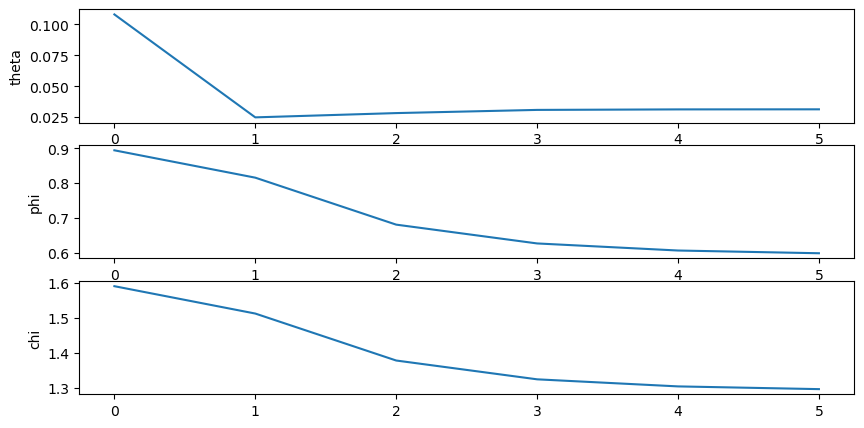

In [19]:
# plot the theta, phi, chi iteration history
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(np.array(iterations)[:, 0])
ax[0].set_ylabel('theta')
ax[1].plot(np.array(iterations)[:, 1])
ax[1].set_ylabel('phi')
ax[2].plot(np.array(iterations)[:, 2])
ax[2].set_ylabel('chi')

# Experiment 2
---
- Fixed experiment design
- one observation \& iterative update
- nested update (Kalman sees batches of increasing depths)

In [20]:
circ_defs = [('+', '0', 0), ('+', '0', np.pi/2), ('r', '0', 0), ('r', '0', np.pi/2)]
depths = [1, 2, 4, 8, 16, 32, 64, 128]
edesign1 = {d: circ_defs for d in depths}
num_shots = 1000
r = 0.25/num_shots
num_iter = 100
tol = 'R-dependent'

In [21]:
state0 = np.array([np.pi/4, 0.2, 0.4])
Pinitial = 0.1*np.eye(3)
xinitial = np.random.multivariate_normal(state0, Pinitial)
Q = 0*np.eye(3)
print(f'initial state: {state0}')
print(f'initial estimate: {xinitial}')
print(f'initial rms error: {np.linalg.norm(xinitial - state0)}')
print(f'Error in theta: {xinitial[0] - state0[0]}')
print(f'Error in phi: {xinitial[1] - state0[1]}')
print(f'Error in chi: {xinitial[2] - state0[2]}')
kf = KalmanFilter(xinitial, Pinitial, Q=Q)
initial_pred = edesign_probability(xinitial, edesign1)


initial state: [0.78539816 0.2        0.4       ]
initial estimate: [1.05931788 0.32299984 0.5587692 ]
initial rms error: 0.33965958326462076
Error in theta: 0.27391971690578965
Error in phi: 0.12299984264917235
Error in chi: 0.15876920325436772


In [22]:
observation = edesign_observation(state0, edesign1, num_shots)

In [23]:
for idx, d in enumerate(depths):
    sub_obs = observation[:4*idx+4]
    sub_edesign = dict()
    for i in range(idx+1):
        sub_edesign[depths[i]] = edesign1[depths[i]]
    kf.iterated_update(sub_obs, sub_edesign, r, max_iter=num_iter, tol=tol)    

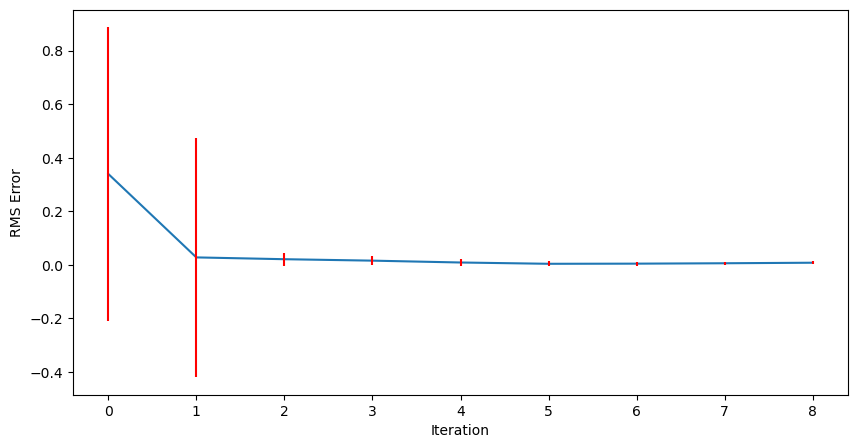

In [24]:
kf.plot_rms_history(state0)

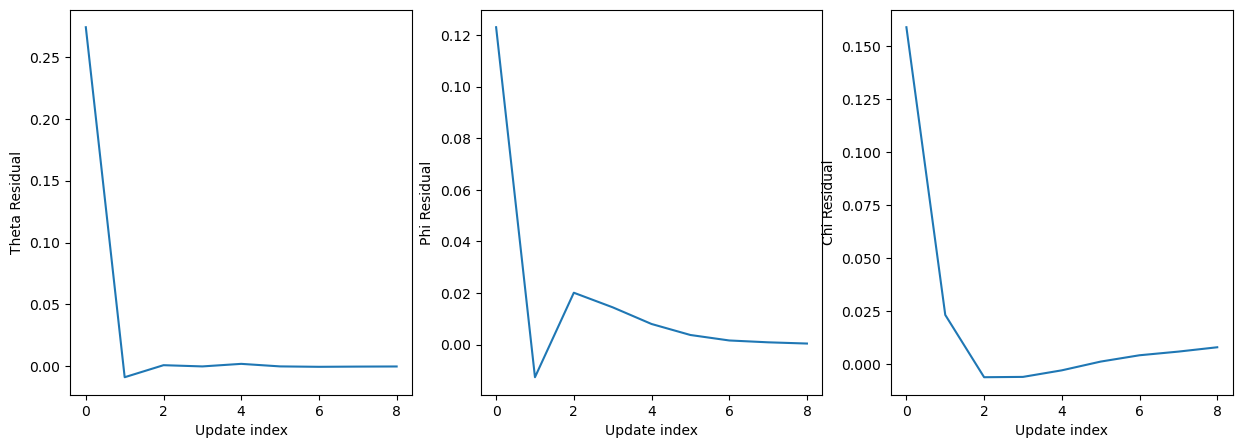

In [25]:
kf.plot_residual_history(state0)

In [26]:
print('final error in theta: ', kf.x[0] - state0[0])
print('final error in phi: ', kf.x[1] - state0[1])
print('final error in chi: ', kf.x[2] - state0[2])

final error in theta:  -0.00014884876678233905
final error in phi:  0.0004482263850518753
final error in chi:  0.00792309187857937


# Experiment 2
---
- Fixed experiment design
- one observation \& iterative update
- single-circuit update (no nesting)

In [27]:
circ_defs = [('+', '0', 0), ('+', '0', np.pi/2), ('r', '0', 0), ('r', '0', np.pi/2)]
depths = [1, 2, 4, 8, 16, 32, 64, 128]
edesign1 = {d: circ_defs for d in depths}
num_shots = 10000
r = 0.25/num_shots
num_iter = 100
tol = 'R-dependent'

In [28]:
state0 = np.array([0.01, 0.2, 0.4])
Pinitial = 0.1*np.eye(3)
xinitial = np.random.multivariate_normal(state0, Pinitial)
Q = 0*np.eye(3)
print(f'initial state: {state0}')
print(f'initial estimate: {xinitial}')
print(f'initial rms error: {np.linalg.norm(xinitial - state0)}')
print(f'Error in theta: {xinitial[0] - state0[0]}')
print(f'Error in phi: {xinitial[1] - state0[1]}')
print(f'Error in chi: {xinitial[2] - state0[2]}')
kf = KalmanFilter(xinitial, Pinitial, Q=Q)
initial_pred = edesign_probability(xinitial, edesign1)


initial state: [0.01 0.2  0.4 ]
initial estimate: [-0.22638286  0.66951167  0.49279387]
initial rms error: 0.5337871925470808
Error in theta: -0.23638286132062586
Error in phi: 0.46951166839626274
Error in chi: 0.09279387394071881


In [29]:
observation = edesign_observation(state0, edesign1, num_shots)

In [30]:
for idx, d in enumerate(depths):
    sub_obs = observation[4*idx:(4*idx+4)]
    sub_edesign = dict()
    sub_edesign[d] = edesign1[d]
    kf.iterated_update(sub_obs, sub_edesign, r, max_iter=num_iter, tol=tol)    

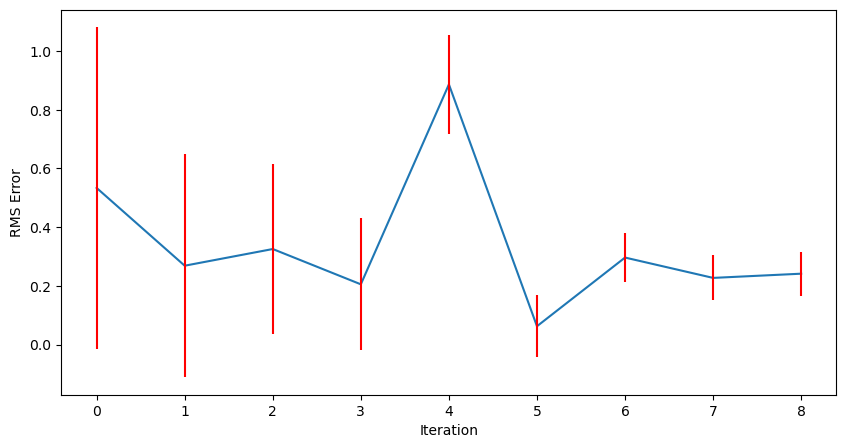

In [31]:
kf.plot_rms_history(state0)

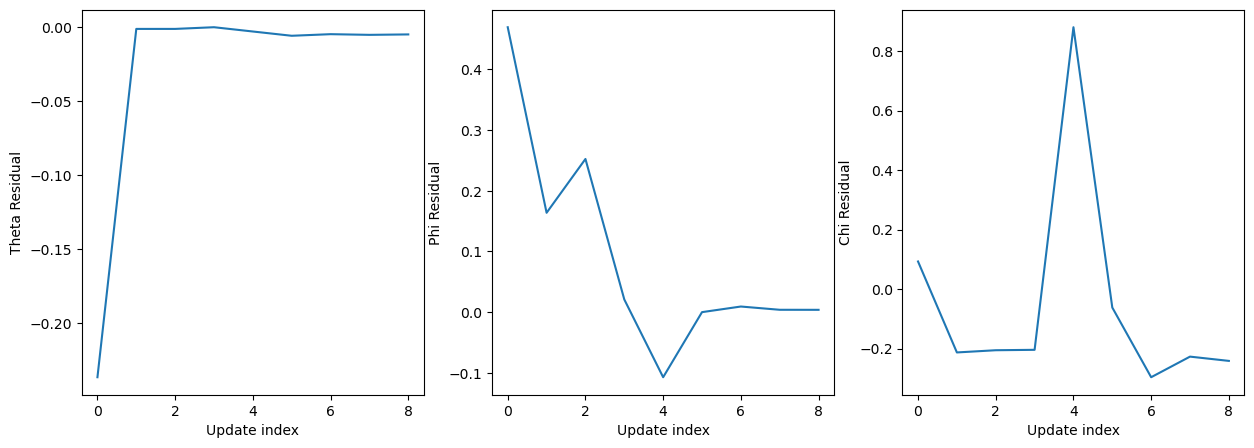

In [32]:
kf.plot_residual_history(state0)

In [33]:
print('final error in theta: ', kf.x[0] - state0[0])
print('final error in phi: ', kf.x[1] - state0[1])
print('final error in chi: ', kf.x[2] - state0[2])

final error in theta:  -0.0048762229565186156
final error in phi:  0.0038606030374324918
final error in chi:  -0.24137041177403773


# Experiment 4:

Bootstrapping and comparison of nested vs single-circuit updates

In [34]:
def single_filter(kfilter, observations, edesign, r, num_iter=100, tol='R-dependent'):
    for idx, d in enumerate(depths):
        sub_obs = observations[4*idx:(4*idx+4)]
        sub_edesign = dict()
        sub_edesign[d] = edesign[d]
        kfilter.iterated_update(sub_obs, sub_edesign, r, max_iter=num_iter, tol=tol)
    return kfilter

def nested_filter(kfilter, observations, edesign, r, num_iter=100, tol='R-dependent'):
    for idx, d in enumerate(depths):
        sub_obs = observations[:4*idx+4]
        sub_edesign = dict()
        for i in range(idx+1):
            sub_edesign[depths[i]] = edesign[depths[i]]
        kfilter.iterated_update(sub_obs, sub_edesign, r, max_iter=num_iter, tol=tol)
    return kfilter

In [35]:
circ_defs = [('+', '0', 0), ('+', '0', np.pi/2), ('r', '0', 0), ('r', '0', np.pi/2)]
depths = [1, 2, 3, 4, 8, 16, 32, 64]
edesign1 = {d: circ_defs for d in depths}
num_shots = 10000
r = 0.25/num_shots
num_iter = 100
tol = 'R-dependent'

In [43]:
uncertainty = 0.001
Pinitial = uncertainty*np.eye(3)
xinitial = np.random.multivariate_normal(state0, Pinitial)
Q = 0*np.eye(3)

In [44]:
np.sqrt(uncertainty)

0.03162277660168379

In [37]:
num_trials = 100
all_xs = []
all_nested_filters = []
all_single_filters = []
for _ in range(num_trials):
    state0 = np.random.rand(3)
    all_xs.append(state0)
    xinitial = np.random.multivariate_normal(state0, Pinitial)
    kf_nested = KalmanFilter(xinitial, Pinitial, Q=Q)
    kf_single = KalmanFilter(xinitial, Pinitial, Q=Q)
    observation = edesign_observation(state0, edesign1, num_shots)
    nested_filter(kf_nested, observation, edesign1, r, num_iter=num_iter, tol=tol)
    single_filter(kf_single, observation, edesign1, r, num_iter=num_iter, tol=tol)
    all_nested_filters.append(kf_nested)
    all_single_filters.append(kf_single)

Text(0.5, 1.0, 'Single Filter')

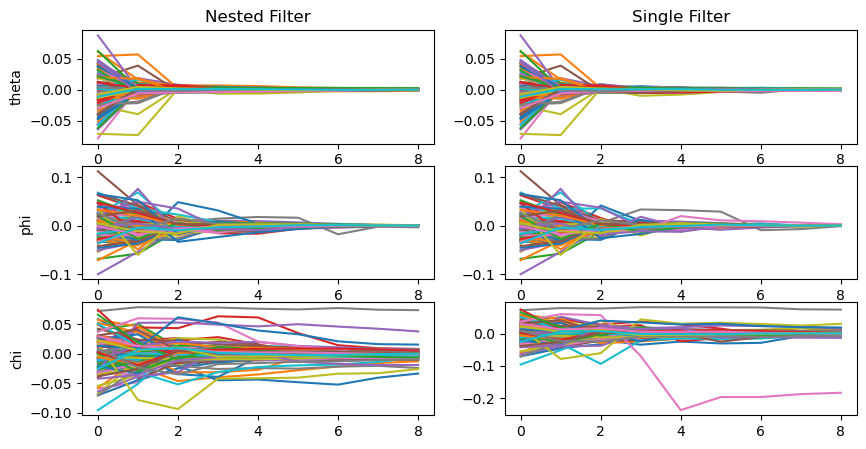

In [38]:
# show theta, phi, chi error trajectories of both filters 
fig, ax = plt.subplots(3, 2, figsize=(10, 5))
for idx, kf in enumerate(all_nested_filters):
    theta_error = np.array([x[0] for x in kf.history['x']]) - all_xs[idx][0]
    phi_error = np.array([x[1] for x in kf.history['x']]) - all_xs[idx][1]
    chi_error = np.array([x[2] for x in kf.history['x']]) - all_xs[idx][2]
    ax[0, 0].plot(theta_error)
    ax[1, 0].plot(phi_error)
    ax[2, 0].plot(chi_error)
for idx, kf in enumerate(all_single_filters):
    theta_error = np.array([x[0] for x in kf.history['x']]) - all_xs[idx][0]
    phi_error = np.array([x[1] for x in kf.history['x']]) - all_xs[idx][1]
    chi_error = np.array([x[2] for x in kf.history['x']]) - all_xs[idx][2]
    ax[0, 1].plot(theta_error)
    ax[1, 1].plot(phi_error)
    ax[2, 1].plot(chi_error)
    
ax[0, 0].set_ylabel('theta')
ax[1, 0].set_ylabel('phi')
ax[2, 0].set_ylabel('chi')
ax[0, 0].set_title('Nested Filter')
ax[0, 1].set_title('Single Filter')

Text(0.5, 1.0, 'Single Filter')

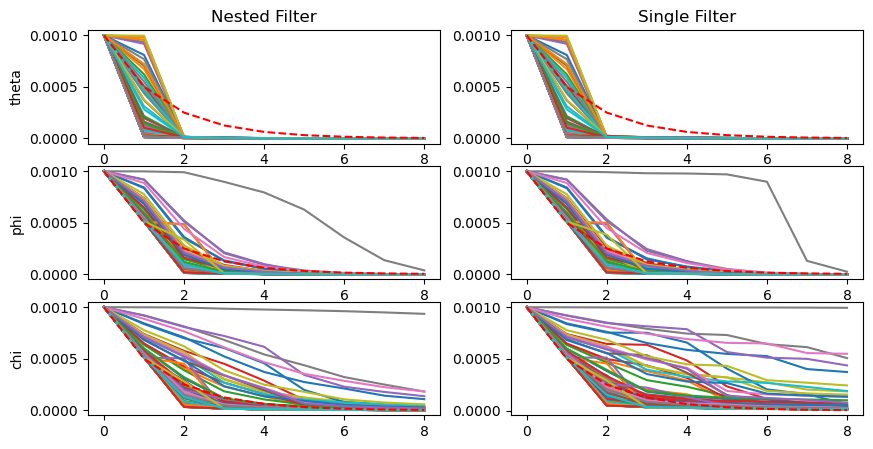

In [39]:
# plot the variance of the estimates at each iteration
fig, ax = plt.subplots(3, 2, figsize=(10, 5))

for idx, kf in enumerate(all_nested_filters):
    theta_var = np.array([P[0, 0] for P in kf.history['P']])
    phi_var = np.array([P[1, 1] for P in kf.history['P']])
    chi_var = np.array([P[2, 2] for P in kf.history['P']])
    ax[0, 0].plot(theta_var)
    ax[1, 0].plot(phi_var)
    ax[2, 0].plot(chi_var)

for idx, kf in enumerate(all_single_filters):
    theta_var = np.array([P[0, 0] for P in kf.history['P']])
    phi_var = np.array([P[1, 1] for P in kf.history['P']])
    chi_var = np.array([P[2, 2] for P in kf.history['P']])
    ax[0, 1].plot(theta_var)
    ax[1, 1].plot(phi_var)
    ax[2, 1].plot(chi_var)

xvals = [i for i in range(len(all_nested_filters[0].history['P']))]
yvals = [uncertainty/2**x for x in xvals]
# make the line 0.03/x
for i in range(3):
    for j in range(2):
        ax[i, j].plot(xvals, yvals, 'r--')

    
ax[0, 0].set_ylabel('theta')
ax[1, 0].set_ylabel('phi')
ax[2, 0].set_ylabel('chi')
ax[0, 0].set_title('Nested Filter')
ax[0, 1].set_title('Single Filter')

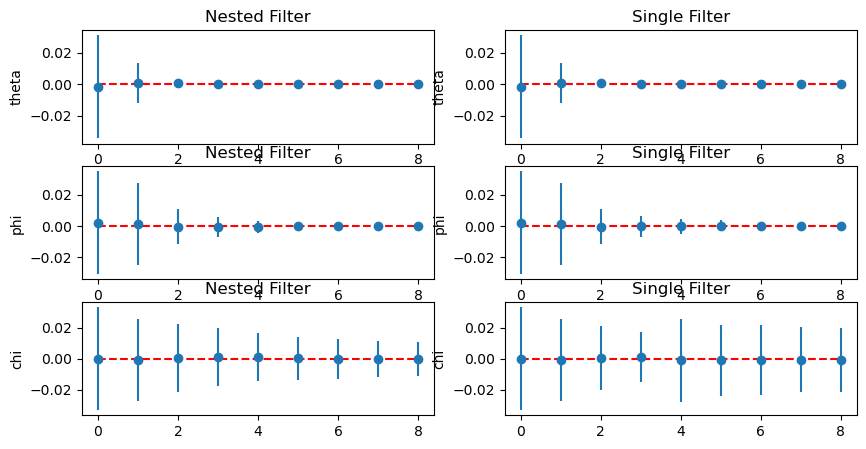

In [40]:
# plot the bootstrapped mean error
fig, ax = plt.subplots(3, 2, figsize=(10, 5))

nested_errors = []
single_errors = []
for idx, kf in enumerate(all_nested_filters):
    nested_errors.append(kf.history['x'] - all_xs[idx])
for idx, kf in enumerate(all_single_filters):
    single_errors.append(kf.history['x'] - all_xs[idx])
nested_errors = np.array(nested_errors)
single_errors = np.array(single_errors)
nested_mean = np.mean(nested_errors, axis=0)
single_mean = np.mean(single_errors, axis=0)
nested_std = np.std(nested_errors, axis=0)
single_std = np.std(single_errors, axis=0)
for i in range(3):
    ax[i, 0].errorbar(xvals, nested_mean[:, i], yerr=nested_std[:, i], fmt='o')
    ax[i, 1].errorbar(xvals, single_mean[:, i], yerr=single_std[:, i], fmt='o')
    ax[i, 0].plot(xvals, [0]*len(xvals), 'r--')
    ax[i, 1].plot(xvals, [0]*len(xvals), 'r--')
    ax[i, 0].set_ylabel(['theta', 'phi', 'chi'][i])
    ax[i, 1].set_ylabel(['theta', 'phi', 'chi'][i])
    ax[i, 0].set_title('Nested Filter')
    ax[i, 1].set_title('Single Filter')

Text(0.5, 1.0, 'Single Filter')

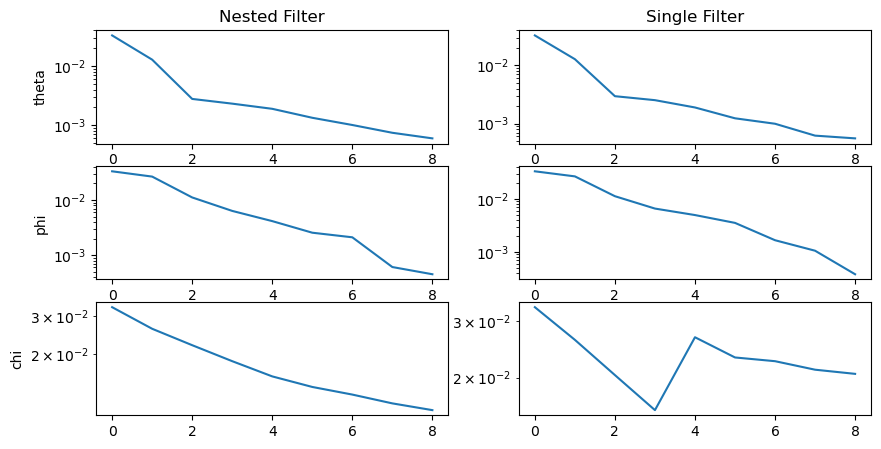

In [46]:
# plot the bootstrapped variance
fig, ax = plt.subplots(3, 2, figsize=(10, 5))

nested_errors = []
single_errors = []
for idx, kf in enumerate(all_nested_filters):
    nested_errors.append(kf.history['x'] - all_xs[idx])
for idx, kf in enumerate(all_single_filters):
    single_errors.append(kf.history['x'] - all_xs[idx])
nested_errors = np.array(nested_errors)
single_errors = np.array(single_errors)
nested_var = np.sqrt(np.var(nested_errors, axis=0))
single_var = np.sqrt(np.var(single_errors, axis=0))
for i in range(3):
    ax[i, 0].semilogy(nested_var[:, i])
    ax[i, 1].semilogy(single_var[:, i])

# xvals = [i for i in range(len(all_nested_filters[0].history['P']))]
# yvals = [uncertainty/2**x for x in xvals]
# # make the line 0.03/x
# for i in range(3):
#     for j in range(2):
#         ax[i, j].plot(xvals, yvals, 'r--')

    
ax[0, 0].set_ylabel('theta')
ax[1, 0].set_ylabel('phi')
ax[2, 0].set_ylabel('chi')
ax[0, 0].set_title('Nested Filter')
ax[0, 1].set_title('Single Filter')

In [ ]:
xnew = x0 + np.random.multivariate_normal([0, 0, 0], (1/25)*np.eye(3))

In [48]:
2 pi * 1 Mhz * 20 ns 

0.04

In [49]:
2*np.pi*1e6*20e-9

0.12566370614359174

In [50]:
xinitial

array([0.69014857, 0.95499651, 0.98706019])

In [51]:
state0

array([0.70242958, 0.94632683, 0.95249835])